# Imports & Load Data
作業に必要なライブラリをインポートして、 以下のデータを読み込みます。

* stock_price : 株価情報
* stock_list : 銘柄情報
* stock_fin : 財務諸表
* stock_labels : 目的変数

In [1]:
!pip install keras
!pip install tensorflow

In [577]:
import os
import pickle
import sys
import warnings
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import  xgboost as xgb
from scipy.stats import spearmanr
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.auto import tqdm

# Sequentialのインポート
from keras.models import Sequential
# Dense、LSTMのインポート
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
import keras
from scipy import stats
from keras.layers import LeakyReLU


# 表示用の設定を変更します
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120

In [3]:
# python 3.7.3であることを確認します
import sys
print(sys.version)

3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]


In [4]:
# データセット保存先ディレクトリ（""の中身はご自身の環境に合わせて定義してください。）
dataset_dir="/path/to"

In [5]:
# 読み込むファイルを定義します。
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv.gz",
    "stock_price": f"{dataset_dir}/stock_price.csv.gz",
    "stock_fin": f"{dataset_dir}/stock_fin.csv.gz",
    # 本チュートリアルでは使用しないため、コメントアウトしています。
    #"stock_fin_price": f"{dataset_dir}/stock_fin_price.csv.gz",
    "stock_labels": f"{dataset_dir}/stock_labels.csv.gz",
}

# ファイルを読み込みます
dfs = {}
for k, v in inputs.items():
    print(k)
    dfs[k] = pd.read_csv(v)

stock_list
stock_price
stock_fin
stock_labels


# 特徴量の生成

In [6]:
FEATURES = ['MA_gap_2month',
            'MA_gap_3month',
            'volatility_2month',
            'volatility_3month',
            'Result_Dividend FiscalYear',
            'return_3month',
            'Forecast_Dividend FiscalYear',
            'volatility_1month',
            'Forecast_FinancialStatement FiscalYear',
            'MA_gap_1month',
            'pbr',
            'Result_FinancialStatement FiscalYear',
            'return_1month',
            'ema_12',
            'Result_FinancialStatement TotalAssets',
            'signal',
            'Previous_FinancialStatement NetIncome',
            'per',
            'Result_FinancialStatement CashFlowsFromOperatingActivities',
            'Result_FinancialStatement CashFlowsFromInvestingActivities',
            'ema_10']

In [7]:
def get_feature_columns(dfs, train_X, column_group="fundamental+technical"):
    # 特徴量グループを定義
    # ファンダメンタル
    fundamental_cols = dfs["stock_fin"].select_dtypes("float64").columns
    fundamental_cols = fundamental_cols[
        fundamental_cols != "Result_Dividend DividendPayableDate"
        ]
    fundamental_cols = fundamental_cols[fundamental_cols != "Local Code"]
    # 価格変化率
    returns_cols = [x for x in train_X.columns if "return" in x]
    # テクニカル
    technical_cols = [
        x for x in train_X.columns if
        (x not in fundamental_cols) and (x != "code")
    ]
    columns = {
        "fundamental_only": fundamental_cols,
        "return_only": returns_cols,
        "technical_only": technical_cols,
        "fundamental+technical": list(fundamental_cols) + list(
            technical_cols),
        "selected_columns":FEATURES,
    }
    return columns[column_group]

In [8]:
model_path = os.path.join(os.path.dirname("__file__"), "../model")
test_X_path = os.path.join(os.path.dirname("__file__"), "../model/proceed_datas/test_X")
test_y_path = os.path.join(os.path.dirname("__file__"), "../model/proceed_datas/test_y")
val_X_path = os.path.join(os.path.dirname("__file__"), "../model/proceed_datas/val_X")
val_y_path = os.path.join(os.path.dirname("__file__"), "../model/proceed_datas/val_y")
train_X_path = os.path.join(os.path.dirname("__file__"), "../model/proceed_datas/train_X")
train_y_path = os.path.join(os.path.dirname("__file__"), "../model/proceed_datas/train_y")

In [9]:
# 対象の目的変数を定義
labels = {
#    "label_high_5",
#    "label_high_10",
    "label_high_20",
#    "label_low_5",
#    "label_low_10",
    "label_low_20",
}

In [12]:
# 特徴量追加済みデータ
proceed_datas = {
    "train_X",
    "train_y",
    "val_X",
    "val_y",
    "test_X",
    "test_y"
}

In [31]:
label = 'label_high_20'
data_X = os.path.join(train_X_path, f"train_X_{label}.pkl")
with open(data_X , "rb") as f:
    train_X = pickle.load(f)
data_y = os.path.join(train_y_path, f"train_y_{label}.pkl")
with open(data_y , "rb") as f:
    train_y = pickle.load(f)
    
data_X = os.path.join(test_X_path, f"test_X_{label}.pkl")
with open(data_X , "rb") as f:
    test_X = pickle.load(f)
data_y = os.path.join(test_y_path, f"test_y_{label}.pkl")
with open(data_y , "rb") as f:
    test_y = pickle.load(f)
    
data_X = os.path.join(val_X_path, f"val_X_{label}.pkl")
with open(data_X , "rb") as f:
    val_X = pickle.load(f)
data_y = os.path.join(val_y_path, f"val_y_{label}.pkl")
with open(data_y , "rb") as f:
    val_y = pickle.load(f)

In [32]:
train_X = train_X.drop(columns=["code"])
test_X = test_X.drop(columns=["code"])
val_X = val_X.drop(columns=["code"])

In [84]:
train_X = stats.zscore(train_X)
test_X = stats.zscore(test_X)
val_X = stats.zscore(val_X)

In [85]:
data_X = os.path.join(model_path, "feature.pkl")
with open(data_X , "rb") as f:
    feature = pickle.load(f)

In [86]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape, val_X.shape, val_y.shape

((31752, 63), (31752,), (32515, 63), (32515,), (14585, 63), (14585,))

In [606]:
# ネットワークの各層のサイズの定義
num_l1 = 64
num_l2 = 64
num_l3 = 64
num_l4 = 64
num_l5 = 64
num_output = 1

# 以下、ネットワークを構築
model = Sequential()
# 第1層
model.add(Dense(num_l1, activation='tanh', input_shape=(train_X.shape[1], )))
model.add(BatchNormalization())
#model.add(Dense(256, input_shape=(3,), kernel_initializer='he_normal'))
#model.add(LeakyReLU(alpha=0.01))
# 第2層
model.add(Dense(num_l2, activation='tanh'))
model.add(BatchNormalization())
# 第3層
model.add(Dense(num_l3, activation='tanh'))
model.add(BatchNormalization())
# 第4層
#model.add(Dense(num_l4, activation='tanh'))
#model.add(BatchNormalization())
# 第5層
#model.add(Dense(num_l5, activation='tanh'))
#model.add(BatchNormalization())
# 出力層
model.add(Dense(num_output))
# ネットワークのコンパイル
model.compile(loss='mse', optimizer=keras.optimizers.Adam(0.001), metrics=['mae'])

In [607]:
model.summary()

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_202 (Dense)            (None, 64)                4096      
_________________________________________________________________
batch_normalization_8 (Batch (None, 64)                256       
_________________________________________________________________
dense_203 (Dense)            (None, 64)                4160      
_________________________________________________________________
batch_normalization_9 (Batch (None, 64)                256       
_________________________________________________________________
dense_204 (Dense)            (None, 64)                4160      
_________________________________________________________________
batch_normalization_10 (Batc (None, 64)                256       
_________________________________________________________________
dense_205 (Dense)            (None, 1)               

In [608]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [609]:
result = model.fit(x=train_X, y=train_y, epochs=1000, validation_data=(val_X, val_y), callbacks=[early_stop])

Epoch 1/1000
993/993 [==============================] - 5s 4ms/step - loss: 0.1377 - mae: 0.2456 - val_loss: 0.0316 - val_mae: 0.1257
Epoch 2/1000
993/993 [==============================] - 3s 3ms/step - loss: 0.0387 - mae: 0.1218 - val_loss: 0.0246 - val_mae: 0.1045
Epoch 3/1000
993/993 [==============================] - 3s 3ms/step - loss: 0.0300 - mae: 0.1062 - val_loss: 0.0232 - val_mae: 0.0995
Epoch 4/1000
993/993 [==============================] - 3s 3ms/step - loss: 0.0320 - mae: 0.1043 - val_loss: 0.0220 - val_mae: 0.0976
Epoch 5/1000
993/993 [==============================] - 4s 4ms/step - loss: 0.0334 - mae: 0.1002 - val_loss: 0.0232 - val_mae: 0.1001
Epoch 6/1000
993/993 [==============================] - 4s 4ms/step - loss: 0.0310 - mae: 0.0989 - val_loss: 0.0211 - val_mae: 0.0960
Epoch 7/1000
993/993 [==============================] - 4s 4ms/step - loss: 0.0329 - mae: 0.1002 - val_loss: 0.0209 - val_mae: 0.0908
Epoch 8/1000
993/993 [==============================] - 4s 4ms

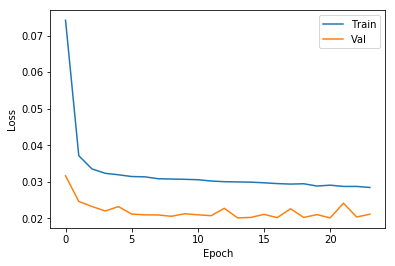

In [610]:
# matplotlibのインポート
from matplotlib import pyplot as plt

# 折れ線グラフによる学習データの損失の描画
plt.plot(result.history['loss'])

# 折れ線グラフによる検証データの損失の描画
plt.plot(result.history['val_loss'])

# 凡例の指定
plt.legend(['Train', 'Val'])

# グラフの軸タイトルの指定
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 描画の実行
plt.show()

In [611]:
loss, accuracy = model.evaluate(test_X, test_y)

1017/1017 [==============================] - 1s 1ms/step - loss: 0.0301 - mae: 0.1037


In [612]:
# 評価データの正解率の表示
print('評価データの正解率:', accuracy)

評価データの正解率: 0.10372582077980042


In [613]:
loss

0.03010135516524315

In [614]:
pred = model.predict(test_X)

In [615]:
test_y.head(10)

datetime
2019-02-08    0.07854
2019-05-13    0.04379
2019-08-02    0.00498
2019-11-05    0.00841
2020-02-07    0.01212
2020-05-12    0.06815
2020-08-07    0.02430
2020-11-06    0.02804
2019-02-05    0.08726
2019-05-14    0.02496
Name: label_high_20, dtype: float64

In [616]:
test_y.mean()

0.09551068983545992

In [617]:
pred[:10]

array([[0.08544312],
       [0.09164497],
       [0.10368558],
       [0.08654649],
       [0.09036639],
       [0.093906  ],
       [0.10526218],
       [0.10476977],
       [0.08328489],
       [0.08910239]], dtype=float32)

In [618]:
np.average(pred)

0.10555078

In [619]:
spearmanr(test_y, pred)[0]

0.10780774372387054